# Tópicos de BigData em Python — Exemplo Pandas (Colab)

**Disciplina:** Tópicos de BigData em Python  
**Aula:** Pandas — Guia Completo e Didático (com dados sintéticos)  
**Professor:** _Raphael Mauricio Sanches de Jesus_


## Pandas — Guia Completo e Didático (com dados sintéticos)

**Objetivo:** fornecer um *notebook* auto-contido e pronto para aula/estudo, cobrindo **leitura**, **inspeção**, **limpeza**, **seleção**, **datas**, **agregação**, **reshape** (*pivot/melt*), **merge/join/concat**, **rank/rolling**, **tipos** (*category*), **entrada/saída** (CSV, Excel, JSON, Parquet\*), **performance** (dtypes/usecols/chunksize), e **visualização** (matplotlib).

> **Observação**: gráficos são feitos **apenas com matplotlib** e sem estilos/cores específicas para manter a compatibilidade com ambientes didáticos.

## Sumário
1. [Ambiente e versões](#ambiente)
2. [Geração de dados sintéticos](#sinteticos)
3. [Leitura de dados: CSV/Excel/JSON](#leitura)
4. [Inspeção, seleção e `query`](#inspecao)
5. [Limpeza e preparação](#limpeza)
6. [Datas e séries temporais](#datas)
7. [Agregações e `groupby` avançado](#groupby)
8. [Reshape: `pivot`, `pivot_table`, `melt`](#reshape)
9. [Junções: `merge`, `join`, `concat`](#joins)
10. [Ordenação, ranking e janelas: `rolling`, `expanding`](#janela)
11. [Tipos e categorias](#tipos)
12. [Entrada/Saída: `to_csv`, `to_excel`, `to_json`, `to_parquet`*](#io)
13. [Performance: `dtype`, `usecols`, `chunksize`](#performance)
14. [Visualização (matplotlib)](#visualizacao)
15. [Exercícios + Gabaritos](#exercicios)
16. [Anexo: Módulo × Pacote em Python e `__init__.py`](#anexo)

<a id="ambiente"></a>


In [1]:
import sys, platform
import pandas as pd
import numpy as np

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("OS:", platform.platform())

Python: 3.12.12
Pandas: 2.2.2
Numpy: 2.0.2
OS: Linux-6.6.105+-x86_64-with-glibc2.35



<a id="sinteticos"></a>

## 1) Geração de dados sintéticos (auto-contido)

Para tornar o notebook independente de arquivos externos, criamos:
- **Vendas** (`df_vendas`): data, região, produto, **categoria**, **id_cliente**, **nome_cliente**, **valor**
- **Clientes (dim)** (`df_clientes`): id, nome, região, renda
- **Filmes (JSON)**: lista de objetos `{titulo, ano, genero, nota}`
- **Planilha Excel** com duas abas: `Compras` (vendas) e `Clientes` (dimensão)

> Também salvamos versões temporárias (CSV/JSON/XLSX) localmente para exemplificar `read_*`.


In [2]:
from pathlib import Path
from datetime import datetime, timedelta
import json
import pandas as pd
import numpy as np

np.random.seed(42)

base = Path("data")
base.mkdir(exist_ok=True)

### ------------------------ Clientes (dimensão) ------------------------

In [3]:
n_clientes = 120
regioes = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]
nomes = [f"Cliente {i:03d}" for i in range(1, n_clientes+1)]
ids = np.arange(1, n_clientes+1)

df_clientes = pd.DataFrame({
    "id_cliente": ids,
    "nome_cliente": nomes,
    "regiao": np.random.choice(regioes, size=n_clientes, replace=True),
    "renda_mensal": np.random.gamma(2.0, 1500, size=n_clientes).round(2)
})

### ------------------------ Vendas ------------------------

In [4]:
# 365 dias de dados, 14 produtos, 4 categorias
dias = pd.date_range("2024-01-01", periods=365, freq="D")
produtos = [f"Produto_{i:02d}" for i in range(1, 15)]
categorias = {
    "Bebidas": produtos[0:4],
    "Alimentos": produtos[4:8],
    "Higiene": produtos[8:11],
    "Limpeza": produtos[11:14]
}
cat_por_prod = {}
for cat, prods in categorias.items():
    for p in prods:
        cat_por_prod[p] = cat

linhas = 15_000
datas = np.random.choice(dias, size=linhas, replace=True)
ids_cli = np.random.choice(ids, size=linhas, replace=True)
prods = np.random.choice(produtos, size=linhas, replace=True)
valores = np.abs(np.random.normal(120, 60, size=linhas)).clip(5, None).round(2)

### mapeia categoria e região pelo cliente

In [5]:
df_tmp = pd.DataFrame({
    "data": datas,
    "id_cliente": ids_cli,
    "produto": prods,
    "valor": valores
})
df_tmp["categoria"] = df_tmp["produto"].map(cat_por_prod)
df_vendas = df_tmp.merge(df_clientes, on="id_cliente", how="left")

### reordena colunas

In [6]:
df_vendas = df_vendas[[
    "data", "regiao", "id_cliente", "nome_cliente", "produto", "categoria", "valor", "renda_mensal"
]]
df_vendas.sort_values("data", inplace=True, ignore_index=True)

### ------------------------ JSON (filmes) ------------------------

In [7]:
generos = ["Ação", "Drama", "Comédia", "Ficção", "Documentário"]
filmes = []
for i in range(1, 51):
    filmes.append({
        "titulo": f"Filme {i:02d}",
        "ano": int(np.random.choice(np.arange(1980, 2025))),
        "genero": np.random.choice(generos),
        "nota": round(np.random.uniform(1, 10), 1)
    })

### ------------------------ Salva CSV/JSON/Excel ------------------------

In [8]:
df_vendas.to_csv(base / "vendas.csv", index=False, encoding="utf-8")
df_clientes.to_csv(base / "clientes.csv", index=False, encoding="utf-8")
with open(base / "filmes.json", "w", encoding="utf-8") as f:
    json.dump(filmes, f, ensure_ascii=False, indent=2)

with pd.ExcelWriter(base / "dados.xlsx") as w:
    df_vendas.to_excel(w, sheet_name="Compras", index=False)
    df_clientes.to_excel(w, sheet_name="Clientes", index=False)

len(df_vendas), len(df_clientes), len(filmes)

(15000, 120, 50)

<a id="leitura"></a>

## 2) Leitura de dados (CSV, Excel, JSON)

- **CSV**: `pd.read_csv('data/vendas.csv')`
- **Excel**: `pd.read_excel('data/dados.xlsx', sheet_name='Compras')`
- **JSON** (array de objetos): `pd.read_json('data/filmes.json', orient='records')`

In [9]:
import pandas as pd

df_csv = pd.read_csv("data/vendas.csv", parse_dates=["data"])
df_xlsx_compras = pd.read_excel("data/dados.xlsx", sheet_name="Compras", parse_dates=["data"])
df_xlsx_clientes = pd.read_excel("data/dados.xlsx", sheet_name="Clientes")
df_json = pd.read_json("data/filmes.json", orient="records")

# Checagem rápida
print(df_csv.shape, df_xlsx_compras.shape, df_xlsx_clientes.shape, df_json.shape)
df_csv.head(3)

(15000, 8) (15000, 8) (120, 4) (50, 4)


,data,regiao,id_cliente,nome_cliente,produto,categoria,valor,renda_mensal
0,2024-01-01,Sudeste,43,Cliente 043,Produto_11,Higiene,162.63,3037.79
1,2024-01-01,Sul,75,Cliente 075,Produto_05,Alimentos,170.17,1149.31
2,2024-01-01,Centro-Oeste,118,Cliente 118,Produto_08,Alimentos,202.70,3505.88


In [11]:
# Info/Describe básicos
display(df_csv.info())
display(df_csv.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   data          15000 non-null  datetime64[ns]
 1   regiao        15000 non-null  object        
 2   id_cliente    15000 non-null  int64         
 3   nome_cliente  15000 non-null  object        
 4   produto       15000 non-null  object        
 5   categoria     15000 non-null  object        
 6   valor         15000 non-null  float64       
 7   renda_mensal  15000 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 937.6+ KB


None

,data,id_cliente,valor,renda_mensal
count,15000,15000.000000,15000.000000,15000.000000
mean,2024-06-30 09:37:20.640000256,60.448133,120.915226,2949.696061
min,2024-01-01 00:00:00,1.000000,5.000000,271.520000
25%,2024-03-30 00:00:00,30.000000,78.810000,1356.130000
50%,2024-06-30 00:00:00,60.000000,119.675000,2637.620000
75%,2024-10-01 00:00:00,91.000000,160.090000,3653.070000
max,2024-12-30 00:00:00,120.000000,377.930000,10947.000000
std,NaN,34.731292,57.838581,2013.957067


<a id="inspecao"></a>

## 3) Inspeção, seleção e `query`

- Seleções com `[]`, `.loc[]` e `.iloc[]`
- Filtros booleanos
- `query()` (com **crase** para nomes de coluna com espaços/caracteres especiais)

In [12]:
df = df_csv.copy()

# Seleções
primeiras_linhas = df.head(5)
colunas_escolhidas = df[["data", "regiao", "valor"]].head(3)
por_posicao = df.iloc[0:3, 0:4]

# Filtros
sudeste_maior_200 = df[(df["regiao"] == "Sudeste") & (df["valor"] > 200)].head(5)

# query sem espaços
q1 = df.query("regiao == 'Sul' and valor < 50").head(3)

# Demonstração de coluna com espaço => usar crase
df_espaco = df.rename(columns={"nome_cliente": "Nome do Cliente"})
q2 = df_espaco.query("`Nome do Cliente`.str.contains('010')", engine="python").head(3)

primeiras_linhas, colunas_escolhidas, por_posicao, sudeste_maior_200, q1, q2

(        data        regiao  id_cliente nome_cliente     produto  categoria  \
 0 2024-01-01       Sudeste          43  Cliente 043  Produto_11    Higiene   
 1 2024-01-01           Sul          75  Cliente 075  Produto_05  Alimentos   
 2 2024-01-01  Centro-Oeste         118  Cliente 118  Produto_08  Alimentos   
 3 2024-01-01  Centro-Oeste         110  Cliente 110  Produto_05  Alimentos   
 4 2024-01-01  Centro-Oeste          55  Cliente 055  Produto_04    Bebidas   
 
     valor  renda_mensal  
 0  162.63       3037.79  
 1  170.17       1149.31  
 2  202.70       3505.88  
 3  176.36       3461.70  
 4  233.10       4868.09  ,
         data        regiao   valor
 0 2024-01-01       Sudeste  162.63
 1 2024-01-01           Sul  170.17
 2 2024-01-01  Centro-Oeste  202.70,
         data        regiao  id_cliente nome_cliente
 0 2024-01-01       Sudeste          43  Cliente 043
 1 2024-01-01           Sul          75  Cliente 075
 2 2024-01-01  Centro-Oeste         118  Cliente 118,
   

<a id="limpeza"></a>

## 4) Limpeza e preparação

- `isna`, `fillna`, `dropna`
- `drop_duplicates`
- `astype`/conversões
- `str.strip`, `str.lower` etc.

In [13]:
df = df_csv.copy()

# Introduz nulos artificiais em 'valor' e 'categoria' para demonstrar
mask = np.random.rand(len(df)) < 0.01
df.loc[mask, "valor"] = np.nan
mask2 = np.random.rand(len(df)) < 0.01
df.loc[mask2, "categoria"] = np.nan

percent_nulos = df.isna().mean().round(4) * 100
# Preenchimento simples
df["valor"] = df["valor"].fillna(df["valor"].median())
df["categoria"] = df["categoria"].fillna("Desconhecida")

# Duplicatas (exemplo didático)
antes = len(df)
df_dup = pd.concat([df, df.iloc[0:2]], axis=0, ignore_index=True)
apos = len(df_dup)
df_sem_dup = df_dup.drop_duplicates()

percent_nulos, (antes, apos, len(df_sem_dup))

(data            0.00
 regiao          0.00
 id_cliente      0.00
 nome_cliente    0.00
 produto         0.00
 categoria       0.97
 valor           1.07
 renda_mensal    0.00
 dtype: float64,
 (15000, 15002, 14999))

<a id="datas"></a>

## 5) Datas e séries temporais

- `to_datetime` e checagem de tipo
- Agrupamento **mensal** por região com `Grouper(freq='MS')`
- *Resampling* para somas mensais

In [14]:
df = df_csv.copy()
df["data"] = pd.to_datetime(df["data"])

mensal_regiao = (df
    .groupby([pd.Grouper(key="data", freq="MS"), "regiao"])["valor"]
    .sum()
    .unstack("regiao", fill_value=0)
)

resample_mensal = (df.set_index("data")["valor"]
    .resample("MS").sum()
)

mensal_regiao.head(3), resample_mensal.head(3)

(regiao      Centro-Oeste  Nordeste     Norte   Sudeste       Sul
 data                                                            
 2024-01-01      31526.91  30491.17  33629.98  34896.23  29950.89
 2024-02-01      23966.88  28453.56  28617.35  35998.53  25544.87
 2024-03-01      29468.69  30863.97  27829.75  37217.95  31792.22,
 data
 2024-01-01    160495.18
 2024-02-01    142581.19
 2024-03-01    157172.58
 Freq: MS, Name: valor, dtype: float64)

<a id="groupby"></a>

## 6) Agregações e `groupby` avançado

- `agg` com múltiplas funções
- `transform` (ex.: z-score por grupo)
- **Top‑N** por grupo (ex.: top 3 produtos por região no mês)

In [16]:
df = df_csv.copy()

# 6.1 agg múltiplo por categoria
agg_cat = (df.groupby("categoria")["valor"]
             .agg(qtd="count", soma="sum", media="mean", mediana="median")
             .sort_values("soma", ascending=False))

# 6.2 transform: z-score do valor por regiao
df["z_valor_regiao"] = (df.groupby("regiao")["valor"]
                          .transform(lambda s: (s - s.mean())/s.std(ddof=0)))

# 6.3 Top-N por grupo: por mes/regiao, top 3 produtos por soma
df["mes"] = df["data"].dt.to_period('M')
somas = (df.groupby(["mes","regiao","produto"])["valor"]
           .sum()
           .reset_index())
somas["rank"] = (somas.groupby(["mes","regiao"])["valor"]
                       .rank(ascending=False, method="first"))
top3 = somas.query("rank <= 3").sort_values(["mes","regiao","valor"], ascending=[True, True, False])

agg_cat.head(3), df[["regiao","valor","z_valor_regiao"]].head(3), top3.head(9)

(            qtd       soma       media  mediana
 categoria                                      
 Alimentos  4346  524015.89  120.574296  119.945
 Bebidas    4141  498104.60  120.286066  117.790
 Limpeza    3299  396833.86  120.289136  119.970,
          regiao   valor  z_valor_regiao
 0       Sudeste  162.63        0.733517
 1           Sul  170.17        0.844419
 2  Centro-Oeste  202.70        1.379269,
         mes        regiao     produto    valor  rank
 12  2024-01  Centro-Oeste  Produto_13  2905.20   1.0
 1   2024-01  Centro-Oeste  Produto_02  2756.00   2.0
 3   2024-01  Centro-Oeste  Produto_04  2672.60   3.0
 18  2024-01      Nordeste  Produto_05  4139.13   1.0
 16  2024-01      Nordeste  Produto_03  2742.13   2.0
 26  2024-01      Nordeste  Produto_13  2512.37   3.0
 30  2024-01         Norte  Produto_03  2936.38   1.0
 32  2024-01         Norte  Produto_05  2834.70   2.0
 33  2024-01         Norte  Produto_06  2750.62   3.0)

<a id="reshape"></a>

## 7) Reshape de dados

- `pivot` (precisa ser 1:1 no índice/coluna)
- `pivot_table` (agregação quando há repetição)
- `melt` (wide → long)

In [18]:
df = df_csv.copy()
df["mes"] = df["data"].dt.to_period('M')

# pivot_table: soma de valor por mes x regiao
tabela = (df.pivot_table(values="valor", index="mes", columns="regiao",
                         aggfunc="sum", fill_value=0))

# melt: volta a long
tabela_reset = tabela.reset_index()
tabela_melt = tabela_reset.melt(id_vars="mes", var_name="regiao", value_name="valor")

# pivot simples: média de valor por produto (uma coluna por categoria)
media_prod_cat = (df.groupby(["produto","categoria"])["valor"]
                    .mean().reset_index())
# para pivot: índice=produto, colunas=categoria, values=media
pivot_media = media_prod_cat.pivot(index="produto", columns="categoria", values="valor").fillna(0)

tabela.head(3), tabela_melt.head(3), pivot_media.head(3)

(regiao   Centro-Oeste  Nordeste     Norte   Sudeste       Sul
 mes                                                          
 2024-01      31526.91  30491.17  33629.98  34896.23  29950.89
 2024-02      23966.88  28453.56  28617.35  35998.53  25544.87
 2024-03      29468.69  30863.97  27829.75  37217.95  31792.22,
        mes        regiao     valor
 0  2024-01  Centro-Oeste  31526.91
 1  2024-02  Centro-Oeste  23966.88
 2  2024-03  Centro-Oeste  29468.69,
 categoria   Alimentos     Bebidas  Higiene  Limpeza
 produto                                            
 Produto_01        0.0  119.726402      0.0      0.0
 Produto_02        0.0  121.405382      0.0      0.0
 Produto_03        0.0  120.062574      0.0      0.0)

<a id="joins"></a>

## 8) Junções e concatenação

- `merge(left, right, on=..., how=...)` (junção relacional por chave)
- `join` (atalho que alinha principalmente por **índice**)
- `concat([...], axis=0/1)` (empilha/concatena por eixo)

In [19]:
df_v = df_csv.copy()
df_c = df_xlsx_clientes.copy()

# 8.1 merge: enriquece vendas com renda do cliente (chave: id_cliente)
enriquecido = df_v.merge(df_c[["id_cliente","renda_mensal"]], on="id_cliente", how="left")

# 8.2 join: alinhando por índice
left = (df_v.groupby("regiao")["valor"].sum().to_frame("soma_valor"))
right = (df_v.groupby("regiao")["valor"].mean().to_frame("media_valor"))
por_indice = left.join(right, how="inner")

# 8.3 concat: concatenar dois pedaços de um df (axis=0) e lado a lado (axis=1)
part1 = df_v.iloc[:100].reset_index(drop=True)
part2 = df_v.iloc[100:200].reset_index(drop=True)
empilhado = pd.concat([part1, part2], axis=0, ignore_index=True)

lado_a_lado = pd.concat([left, right], axis=1)

enriquecido.head(3), por_indice, empilhado.shape, lado_a_lado.head(3)

(        data        regiao  id_cliente nome_cliente     produto  categoria  \
 0 2024-01-01       Sudeste          43  Cliente 043  Produto_11    Higiene   
 1 2024-01-01           Sul          75  Cliente 075  Produto_05  Alimentos   
 2 2024-01-01  Centro-Oeste         118  Cliente 118  Produto_08  Alimentos   
 
     valor  renda_mensal_x  renda_mensal_y  
 0  162.63         3037.79         3037.79  
 1  170.17         1149.31         1149.31  
 2  202.70         3505.88         3505.88  ,
               soma_valor  media_valor
 regiao                               
 Centro-Oeste   327108.22   122.604280
 Nordeste       363763.92   121.376016
 Norte          346303.88   119.786883
 Sudeste        431894.99   120.204562
 Sul            344657.38   120.889996,
 (200, 8),
               soma_valor  media_valor
 regiao                               
 Centro-Oeste   327108.22   122.604280
 Nordeste       363763.92   121.376016
 Norte          346303.88   119.786883)

<a id="janela"></a>

## 9) Ordenação, ranking e janelas (`rolling`, `expanding`)

- `sort_values`, `rank`
- Médias móveis: `rolling(window=7).mean()`
- Acumulados: `expanding().sum()`

In [20]:
df = df_csv.copy().sort_values(["data","valor"])

# Rolling: média móvel diária do total de vendas
serie_diaria = df.groupby("data")["valor"].sum().sort_index()
mm7 = serie_diaria.rolling(window=7, min_periods=1).mean()
acum = serie_diaria.expanding().sum()

serie_diaria.head(3), mm7.head(10), acum.head(5)

(data
 2024-01-01    5289.93
 2024-01-02    4417.76
 2024-01-03    4215.24
 Name: valor, dtype: float64,
 data
 2024-01-01    5289.930000
 2024-01-02    4853.845000
 2024-01-03    4640.976667
 2024-01-04    4563.245000
 2024-01-05    4571.434000
 2024-01-06    4383.556667
 2024-01-07    4427.630000
 2024-01-08    4651.517143
 2024-01-09    4846.561429
 2024-01-10    5018.812857
 Name: valor, dtype: float64,
 data
 2024-01-01     5289.93
 2024-01-02     9707.69
 2024-01-03    13922.93
 2024-01-04    18252.98
 2024-01-05    22857.17
 Name: valor, dtype: float64)

<a id="tipos"></a>

## 10) Tipos e categorias

- `astype('category')` reduz memória e permite ordenação lógica de rótulos.
- `CategoricalDtype(ordered=True, categories=[...])` para ordem customizada.

In [21]:
from pandas.api.types import CategoricalDtype

df = df_csv.copy()
ordem = ["Norte", "Nordeste", "Centro-Oeste", "Sudeste", "Sul"]
cat_tipo = CategoricalDtype(categories=ordem, ordered=True)
df["regiao"] = df["regiao"].astype(cat_tipo)

df["regiao"].dtype, df["regiao"].cat.categories, df["regiao"].cat.ordered

(CategoricalDtype(categories=['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul'], ordered=True, categories_dtype=object),
 Index(['Norte', 'Nordeste', 'Centro-Oeste', 'Sudeste', 'Sul'], dtype='object'),
 True)

<a id="io"></a>

## 11) Entrada/Saída

- `to_csv`, `to_excel`, `to_json`
- `to_parquet` (\*requer `pyarrow` ou `fastparquet` — tentamos com `try/except`)

In [22]:
out = Path("output")
out.mkdir(exist_ok=True)

amostra = df_csv.sample(1000, random_state=0).sort_values("data")

amostra.to_csv(out / "amostra.csv", index=False, encoding="utf-8")
amostra.to_excel(out / "amostra.xlsx", index=False)
amostra.to_json(out / "amostra.json", orient="records", force_ascii=False, indent=2)

parquet_info = "Parquet não gerado (sem engine)."
try:
    amostra.to_parquet(out / "amostra.parquet", index=False)
    parquet_info = "Parquet gerado com sucesso."
except Exception as e:
    parquet_info = f"Falha no Parquet: {type(e).__name__}: {e}"

parquet_info, list(out.iterdir())[:5]

('Parquet gerado com sucesso.',
 [PosixPath('output/amostra.csv'),
  PosixPath('output/amostra.xlsx'),
  PosixPath('output/amostra.json'),
  PosixPath('output/amostra.parquet')])

<a id="performance"></a>

## 12) Performance: `dtype`, `usecols`, `chunksize`

- **`dtype`**: informa tipos para reduzir memória (ex.: `int32`, `float32`, `category`).
- **`usecols`**: lê apenas colunas necessárias.
- **`chunksize`**: processa em partes para arquivos grandes.

In [23]:
# Exemplo de leitura com usecols + dtype
tipos = {
    "regiao": "category",
    "id_cliente": "int32",
    "nome_cliente": "string",
    "produto": "string",
    "categoria": "category",
    "valor": "float32",
    "renda_mensal": "float32",
}
subset = pd.read_csv("data/vendas.csv",
                     usecols=["data","regiao","id_cliente","produto","valor"],
                     dtype={"regiao":"category","id_cliente":"int32","produto":"string","valor":"float32"},
                     parse_dates=["data"])
mem_mb = subset.memory_usage(deep=True).sum() / (1024**2)

# chunksize: soma total de valor por produto sem carregar tudo de uma vez
somas = {}
for chunk in pd.read_csv("data/vendas.csv", chunksize=5000):
    g = chunk.groupby("produto")["valor"].sum()
    for k,v in g.items():
        somas[k] = somas.get(k, 0.0) + v
somas_res = pd.Series(somas).sort_values(ascending=False).head(5)

mem_mb, somas_res

(np.float64(1.0877456665039062),
 Produto_05    139151.06
 Produto_13    137666.03
 Produto_07    133169.28
 Produto_11    132984.81
 Produto_09    132376.48
 dtype: float64)

<a id="visualizacao"></a>

## 13) Visualização (matplotlib)

> Um gráfico por célula, sem estilos/cores específicas.

- Linha: total diário de vendas
- Barras: total mensal por região
- Histograma: distribuição de valores de venda
- Boxplot: valores por categoria
- Dispersão: renda × valor médio por cliente

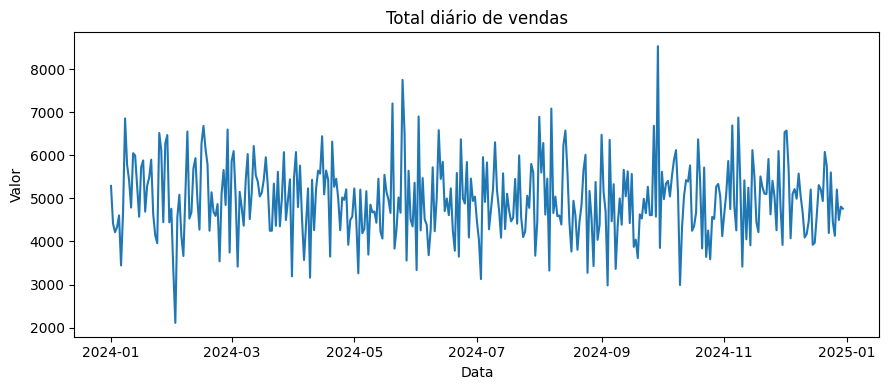

In [24]:
import matplotlib.pyplot as plt

df = df_csv.copy()
serie_diaria = df.groupby("data")["valor"].sum().sort_index()

plt.figure(figsize=(9,4))
plt.plot(serie_diaria.index, serie_diaria.values)
plt.title("Total diário de vendas")
plt.xlabel("Data"); plt.ylabel("Valor")
plt.tight_layout(); plt.show()

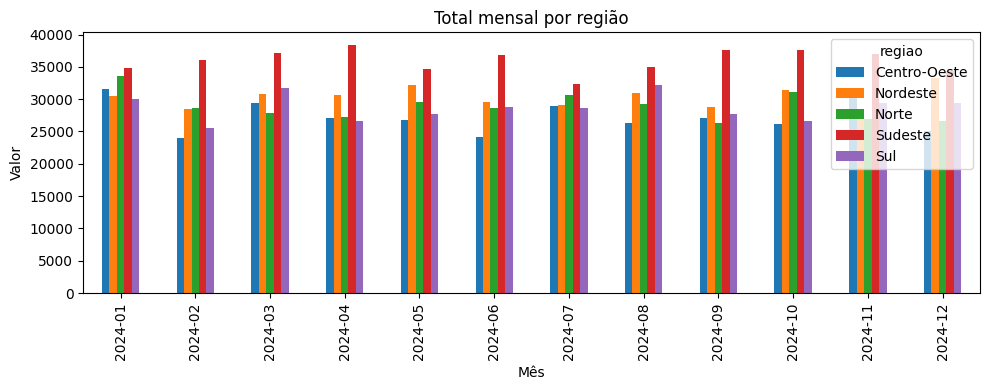

In [27]:
# Barras: total mensal por região
df = df_csv.copy()
df["mes"] = df["data"].dt.to_period("M")
mensal = (df.groupby(["mes","regiao"])["valor"]
            .sum()
            .unstack("regiao", fill_value=0))

plt.figure(figsize=(10,4))
mensal.plot(kind="bar", ax=plt.gca())
plt.title("Total mensal por região")
plt.xlabel("Mês"); plt.ylabel("Valor")
plt.tight_layout(); plt.show()

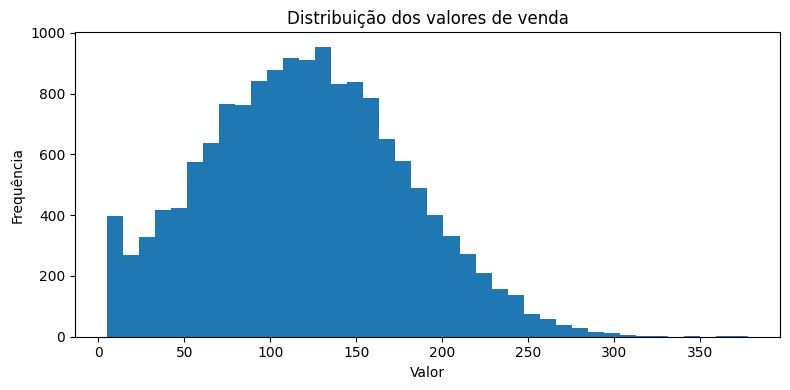

In [28]:
# Histograma de valores individuais
plt.figure(figsize=(8,4))
plt.hist(df_csv["valor"], bins=40)
plt.title("Distribuição dos valores de venda")
plt.xlabel("Valor"); plt.ylabel("Frequência")
plt.tight_layout(); plt.show()

<Figure size 800x400 with 0 Axes>

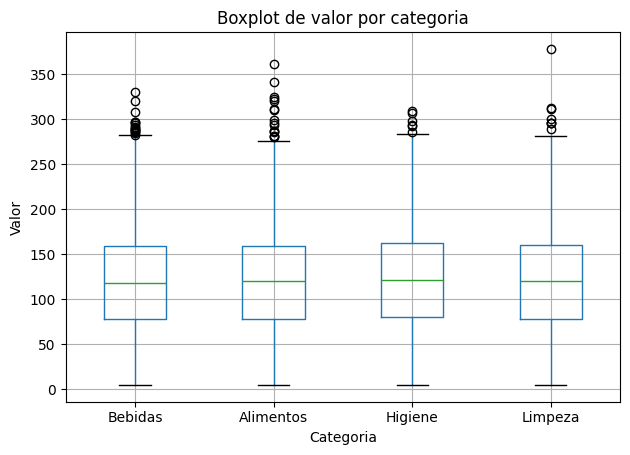

In [29]:
# Boxplot por categoria
ordem = ["Bebidas","Alimentos","Higiene","Limpeza"]
df_ord = df_csv[df_csv["categoria"].isin(ordem)].copy()
df_ord["categoria"] = pd.Categorical(df_ord["categoria"], categories=ordem, ordered=True)

plt.figure(figsize=(8,4))
df_ord.boxplot(column="valor", by="categoria")
plt.title("Boxplot de valor por categoria"); plt.suptitle("")
plt.xlabel("Categoria"); plt.ylabel("Valor")
plt.tight_layout(); plt.show()

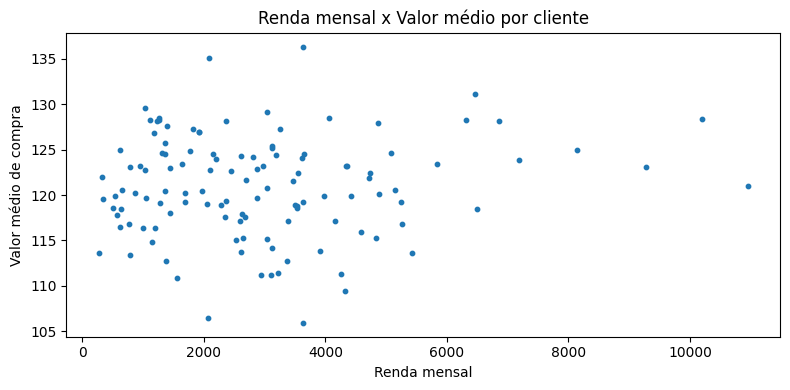

In [30]:
# Dispersão: renda x valor médio por cliente
g = (df_csv.groupby(["id_cliente","nome_cliente"])["valor"]
       .mean()
       .rename("valor_medio")
       .reset_index()
       .merge(df_clientes[["id_cliente","renda_mensal"]], on="id_cliente", how="left"))

plt.figure(figsize=(8,4))
plt.scatter(g["renda_mensal"], g["valor_medio"], s=10)
plt.title("Renda mensal x Valor médio por cliente")
plt.xlabel("Renda mensal"); plt.ylabel("Valor médio de compra")
plt.tight_layout(); plt.show()

<a id="exercicios"></a>

## 14) Exercícios (com gabarito)

**E1.** Listar os **5 produtos** com maior **soma de vendas** em **cada região** no ano.  
**E2.** Calcular, por mês, o **top‑3 produtos** por soma de vendas dentro de cada região.  
**E3.** Encontrar clientes que compraram **em mais de uma categoria** (contagem de categorias > 1).  
**E4.** Criar uma **tabela mensal (linhas)** × **região (colunas)** com somas, e salvar em `output/tabela_mensal.xlsx`.  
**E5.** Calcular a **média móvel de 7 dias** do total diário e plotar.

Gabaritos abaixo.

### E1

In [31]:
df = df_csv.copy()
e1 = (df.groupby(["regiao","produto"])["valor"].sum()
        .reset_index()
        .sort_values(["regiao","valor"], ascending=[True, False])
        .groupby("regiao").head(5))
e1.head(10)

,regiao,produto,valor
3,Centro-Oeste,Produto_04,26901.06
8,Centro-Oeste,Produto_09,25771.95
10,Centro-Oeste,Produto_11,25731.87
11,Centro-Oeste,Produto_12,24722.14
9,Centro-Oeste,Produto_10,23942.36
20,Nordeste,Produto_07,29233.24
18,Nordeste,Produto_05,29071.19
26,Nordeste,Produto_13,28101.55
17,Nordeste,Produto_04,27955.18
16,Nordeste,Produto_03,27523.33


### E2

In [33]:
#já mostrado antes como top3, aqui em forma compacta
df = df_csv.copy()
df["mes"] = df["data"].dt.to_period("M")
somas = (df.groupby(["mes","regiao","produto"])["valor"]
           .sum()
           .reset_index())
somas["rank"] = somas.groupby(["mes","regiao"])["valor"].rank(ascending=False, method="first")
e2 = somas.query("rank <= 3").sort_values(["mes","regiao","valor"], ascending=[True, True, False])
e2.head(12)

,mes,regiao,produto,valor,rank
12,2024-01,Centro-Oeste,Produto_13,2905.20,1.0
1,2024-01,Centro-Oeste,Produto_02,2756.00,2.0
3,2024-01,Centro-Oeste,Produto_04,2672.60,3.0
18,2024-01,Nordeste,Produto_05,4139.13,1.0
16,2024-01,Nordeste,Produto_03,2742.13,2.0
26,2024-01,Nordeste,Produto_13,2512.37,3.0
30,2024-01,Norte,Produto_03,2936.38,1.0
32,2024-01,Norte,Produto_05,2834.70,2.0
33,2024-01,Norte,Produto_06,2750.62,3.0
55,2024-01,Sudeste,Produto_14,4140.76,1.0


### E3

In [34]:
g = (df_csv.groupby(["id_cliente","nome_cliente"])["categoria"]
        .nunique()
        .rename("qtd_categorias"))
e3 = g[g > 1].reset_index().sort_values("qtd_categorias", ascending=False)
e3.head(10)

,id_cliente,nome_cliente,qtd_categorias
0,1,Cliente 001,4
1,2,Cliente 002,4
2,3,Cliente 003,4
3,4,Cliente 004,4
4,5,Cliente 005,4
5,6,Cliente 006,4
6,7,Cliente 007,4
7,8,Cliente 008,4
8,9,Cliente 009,4
9,10,Cliente 010,4


### E4

In [37]:
out = Path("output")
out.mkdir(exist_ok=True)
tabela_mensal = (df_csv
                 .assign(mes=df_csv["data"].dt.to_period("M"))
                 .groupby(["mes","regiao"])["valor"].sum()
                 .unstack("regiao", fill_value=0))
tabela_mensal.to_excel(out / "tabela_mensal.xlsx")
tabela_mensal.head(3)

regiao,Centro-Oeste,Nordeste,Norte,Sudeste,Sul
mes,,,,,
2024-01,31526.91,30491.17,33629.98,34896.23,29950.89
2024-02,23966.88,28453.56,28617.35,35998.53,25544.87
2024-03,29468.69,30863.97,27829.75,37217.95,31792.22


### E5

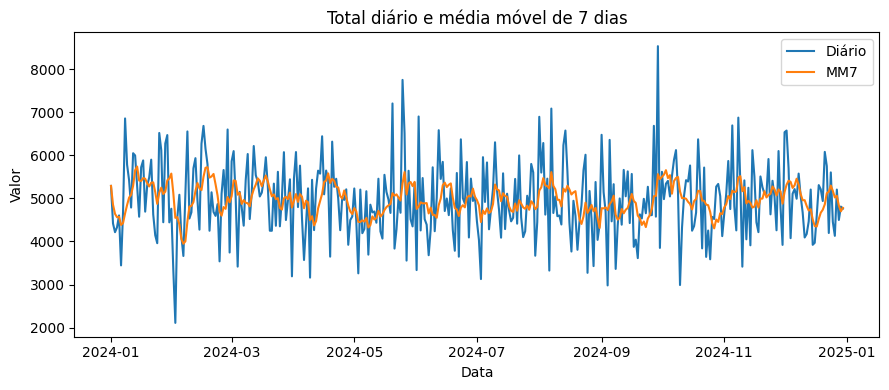

In [38]:
import matplotlib.pyplot as plt

serie_diaria = (df_csv.groupby("data")["valor"]
                .sum()
                .sort_index())
mm7 = serie_diaria.rolling(window=7, min_periods=1).mean()

plt.figure(figsize=(9,4))
plt.plot(serie_diaria.index, serie_diaria.values, label="Diário")
plt.plot(mm7.index, mm7.values, label="MM7")
plt.title("Total diário e média móvel de 7 dias")
plt.xlabel("Data"); plt.ylabel("Valor")
plt.legend()
plt.tight_layout(); plt.show()

<a id="anexo"></a>

## 15) **Anexo** — Python: Módulo × Pacote e `__init__.py`

- **Módulo**: **um arquivo** `.py` (ex.: `modulo.py`).
- **Pacote**: **uma pasta** que contém um `__init__.py` (executado na importação do pacote).
- O método **`__init__` de classe** não é “construtor” em Python; quem cria a instância é `__new__`. O `__init__` apenas **inicializa**.

```
meu_projeto/
└── pacote_exemplo/
    ├── __init__.py      # executa ao importar "import pacote_exemplo"
    └── modulo.py
```

**`pacote_exemplo/modulo.py`**
```python
def diga_ola():
    print("Olá do módulo!")
```

**`pacote_exemplo/__init__.py`**
```python
from .modulo import diga_ola  # reexporta
```

**Uso**
```python
from pacote_exemplo import diga_ola
diga_ola()
```

---

### Arquivos gerados neste notebook
- `data/vendas.csv`, `data/clientes.csv`, `data/filmes.json`, `data/dados.xlsx`
- `output/amostra.csv`, `output/amostra.xlsx`, `output/amostra.json`, `output/amostra.parquet` (se suportado)
- `output/tabela_mensal.xlsx`

> Sinta-se à vontade para adaptar os tamanhos dos dados, categorias, produtos e datas, este notebook é 100% para uso academico, para ajudar no aprendizado do uso das Frameworks aqui utilizadas.